# LSTM Neural network

In dit document wordt een LSTM neuraal netwerk opgesteld om de toekomstige waardes van IC opnames te voorspellen.
Het doel is 7 dagen in de toekomst te kunnen voorspellen doormiddel van de data_per_dag dataset.

De data_per_dag dataset is gekozen omdat deze meer meetwaardes heeft dan de wekelijkse dataset.
Dit betekent dat de leeftijdgroep feature niet mee wordt genomen in het neurale netwerk, omdat deze enkel in de wekelijkse dataset bestaat.

Voor het neurale netwerk wordt gebruik gemaakt van de Keras library.

In [2]:
import pandas as pd
from os import path, getcwd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Dense, LSTM, TimeDistributed, Input, RepeatVector
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Bij het importeren van de data wordt de datum kolom gebruikt als de index, en deze wordt dan vervolgens gesorteerd van eerste tot laatste datum.

In [3]:
# Import data
root_dir = path.join(getcwd(), 'Datasets')
data_per_dag = pd.read_csv(path.join(root_dir, 'data_per_dag.csv'), sep=',', parse_dates=['Date_adj'], index_col=['Date_adj'])
data_per_dag.sort_index(inplace=True)

De series_shift functie wordt gebruikt om de data om te zetten naar een supervised learning probleem.

Dit wordt gedaan door de gekozen kolommen te kopiëren en iedere kolom vervolgens een n aantal dagen naar voren of naar achteren schuiven.
Bijvoorbeeld:

| Origineel 	| t-1  	| t 	| t+1  	|
|-----------	|------	|---	|------	|
| 1         	| null 	| 1 	| 2    	|
| 2         	| 1    	| 2 	| 3    	|
| 3         	| 2    	| 3 	| 4    	|
| 4         	| 3    	| 4 	| null 	|

Dit zet de dataset om naar waardes in het verleden gekoppeld aan waardes van de toekomst, hiermee kan het model getrained worden om te voorspellen.
Hierbij worden wel een aantal waardes verloren, zoals te zien is in het voorbeeld zullen null waardes ontstaan aan het begin en einde, deze rijen worden gedropped.

In [8]:
# Turn data into supervised learning problem
def series_shift(data, lag, n_seq):
    n_features = data.shape[1]
    df = pd.DataFrame(data)

    cols, names = list(), list()

    # x input shifted back from t-n to t-1
    for i in range(lag, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j + 1}(t-{i})' for j in range(n_features)]

    # t output shifted ahead from t to t+n
    for i in range(0, n_seq):
        cols.append(df.shift(-i))
        names += [f'var{j + 1}(t+{i})' for j in range(n_features)]

    # concat data
    new_df = pd.concat(cols, axis=1)
    new_df.columns = names

    # Drop rows with null values created by the shift
    new_df.dropna(inplace=True)

    return new_df

# Example
print(series_shift(data_per_dag[['Opname IC totaal']].values, 1, 2))

     var1(t-1)  var1(t+0)  var1(t+1)
1         35.0         56       68.0
2         56.0         68       83.0
3         68.0         83       84.0
4         83.0         84       75.0
5         84.0         75      100.0
..         ...        ...        ...
589       23.0         21       23.0
590       21.0         23       27.0
591       23.0         27       13.0
592       27.0         13       23.0
593       13.0         23       24.0

[593 rows x 3 columns]


De volgende functie wordt gebruikt om de data te stationair te maken, dit om de trend uit de data te halen zodat het neurale netwerk enkel het patroon overblijft dat aan het neurale netwerk geleerd moet worden.

De data wordt zo vervormd dat het boven en onder de 0 schommelt.

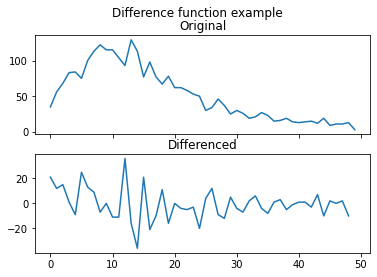

In [11]:
# Difference the data
def difference(data, interval=1):
    diff_data = list()
    for i in range(interval, data.shape[0]):
        diff = list()
        for c in range(data.shape[1]):
            value = data[i, c] - data[i - interval, c]
            diff.append(value)
        diff_data.append(diff)
    return np.array(diff_data)

# Example
test_data = data_per_dag[['Opname IC totaal']].values[0:50]

fig_diff, axs_diff = plt.subplots(2, sharex=True)
fig_diff.suptitle('Difference function example')
axs_diff[0].set_title('Original')
axs_diff[0].plot(test_data)
axs_diff[1].set_title('Differenced')
axs_diff[1].plot(difference(test_data))

De resultaten van het getrainde model zijn dan ook nog steeds differenced, dit process moet omgekeerd worden om de data weer in de originele vorm terug te krijgen.

Dit kan met de volgende functie, hierbij moet echter wel de ongedifferencieërde waarde meegegeven worden, die vóór de eerste waarde in de rij staat.

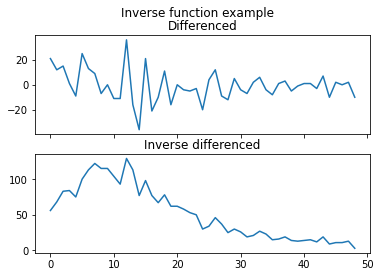

In [12]:
# Reverse difference
def inverse_difference(last_sample, data):
    rev_data = [[], ]

    # Initial reverse using last sample
    for i in range(len(last_sample)):
        rev_data[0].append(data[0][i] + last_sample[i])

    # Propagate the reversing forward
    for i in range(1, data.shape[0]):
        rev_diff = list()
        for c in range(data.shape[1]):
            value = data[i, c] + rev_data[i - 1][c]
            rev_diff.append(value)
        rev_data.append(rev_diff)
    return np.array(rev_data)

# Example
test_inv_data = difference(data_per_dag[['Opname IC totaal']].values[0:50])
start_inv_value = data_per_dag[['Opname IC totaal']].values[0]

fig_inv, axs_inv = plt.subplots(2, sharex=True)
fig_inv.suptitle('Inverse function example')
axs_inv[0].set_title('Differenced')
axs_inv[0].plot(test_inv_data)
axs_inv[1].set_title('Inverse differenced')
axs_inv[1].plot(inverse_difference(start_inv_value, test_inv_data))

Naast het shiften en differencen van de data moet deze ook genormaliseerd worden naar de -1 tot 1 schaal. Dit omdat het LSTM de tanh activatiefunctie zal gebruiken en deze geeft uitkomsten binnen die schaal.

Ook moet de data worden opverdeeld in een train en test set, zodat het model later getest kan worden op data die het nog niet heeft gezien.

Tot slot wordt de data vervormd tot een 3 dimensionale array van de volgende structuur [samples, timesteps, features]
- De samples zijn de individuele waardes die gegeven worden aan het model, één voor iedere regel in de dataset.
- De timesteps zijn de kolommen die volgen uit de hiervoor getoonde series_shift functie. Één voor elke tijdstap, bijvoorbeeld t-1, t en t+1.
- Tot slot zijn er de features, dit zijn de originele kolommen uit de data zoals IC opnames en infecties.

Dit wordt gedaan omdat een LSTM de data in deze vorm verwacht als input.

Al deze voorbereidende stappen worden in één functie samengebracht.

Example test set y
Amount of samples: 100
Amount of timesteps: 2
Amount of features: 2
First 3 samples:
[[[ 0.27777778 -0.01014199]
  [-0.25        0.12778905]]

 [[-0.25        0.12778905]
  [ 0.08333333  0.17241379]]

 [[ 0.08333333  0.17241379]
  [ 0.13888889  0.05476673]]]


Text(0.5, 0.98, 'Example data prep IC Opnames')

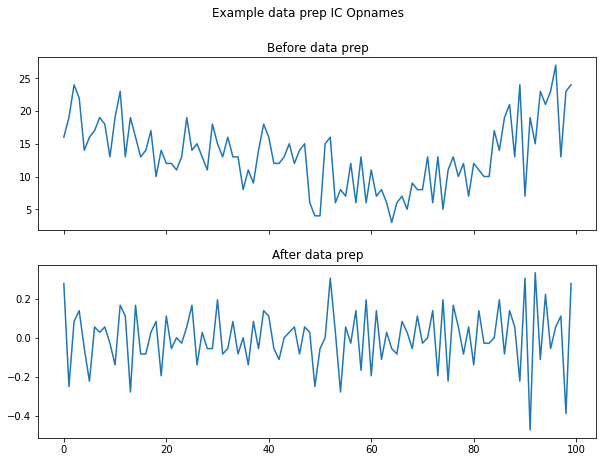

In [28]:
# prepera data
def prep_data(data, n_tests, n_lag, n_seq):
    # DataFrame -> numpy array
    values = data.values

    # Create shifted data by n amount of time step lags and n_seq steps horizon
    data_supervised = series_shift(values, n_lag, n_seq)

    # Difference the data
    diff_data = difference(data_supervised.values)

    # Train test split
    train, test = diff_data[0:-n_tests], diff_data[-n_tests:]

    # scale data from -1 to 1 to match activation function tanh
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_train = scaler.fit_transform(train)

    # y is scaled by the scaled fit to the train set
    scaled_test = scaler.transform(test)

    # The data currently has all time steps attached in a single 2D array [samples, features], reshape this to a 3D array of [samples, timesteps, features]
    reshaped_train = np.reshape(scaled_train, (scaled_train.shape[0], n_lag + n_seq, values.shape[1]))
    reshaped_test = np.reshape(scaled_test, (scaled_test.shape[0], n_lag + n_seq, values.shape[1]))

    # Currently X and y are attached to eachother, the last n_seq time steps are the y value.
    train_X, train_y = reshaped_train[:, :-n_seq, :], reshaped_train[:, -n_seq:, :]
    test_X, test_y = reshaped_test[:, :-n_seq, :], reshaped_test[:, -n_seq:, :]

    return train_X, train_y, test_X, test_y, scaler

# Show example
sample_prep = prep_data(data_per_dag[['Opname IC totaal', 'Opname verpleegafdeling totaal']], 100, 1, 2)
print('Example test set y')
print(f'Amount of samples: {sample_prep[3].shape[0]}')
print(f'Amount of timesteps: {sample_prep[3].shape[1]}')
print(f'Amount of features: {sample_prep[3].shape[2]}')
print(f'First 3 samples:\n{sample_prep[3][0:3]}')

fig_prep, axs_prep = plt.subplots(2, figsize=(10, 7), sharex=True)
axs_prep[0].set_title('Before data prep')
axs_prep[0].plot(data_per_dag[['Opname IC totaal']].values[-100:])
axs_prep[1].set_title('After data prep')
axs_prep[1].plot(sample_prep[3][:, 0, 0])
fig_prep.suptitle('Example data prep IC Opnames')

Omdat de originele data terug te krijgen moet de normalisatie en de differencing ongedaan worden. Hiervoor bestaat de volgende functie.

Om de inverse functie van de normalisatie te gebruiken moet de data in dezelfde vorm zijn als deze was wanneer de normalisatie werd toegepast. Dus de data wordt tijdelijk weer samengevoegd naar een 2 dimensionele array, en dan weer terug naar 3D.

In [31]:
def inverse_scale(data_X, data_y, scaler, original_samples, n_seq):

    # Merge data together into the shape it had when it was scaled
    reshaped_X = data_X.reshape(data_X.shape[0], data_X.shape[1] * data_X.shape[2])
    reshaped_y = data_y.reshape(data_y.shape[0], data_y.shape[1] * data_y.shape[2])

    data_merged = np.concatenate([reshaped_X, reshaped_y], axis=1)

    # Revert the scaling
    inverse = scaler.inverse_transform(data_merged)

    # Undo the merge
    reshaped_inverse = inverse.reshape((data_X.shape[0]), data_X.shape[1] + data_y.shape[1], data_X.shape[2])
    scaled_X, scaled_y = reshaped_inverse[:, :-n_seq, :], reshaped_inverse[:, -n_seq:, :]

    inverted = list()

    for i in range(scaled_y.shape[0]):
        # Revert the differencing
        rev_diff = inverse_difference(original_samples[i], scaled_y[i])

        inverted.append(rev_diff)

    return scaled_X, np.array(inverted)

Vervolgens wordt het model opgesteld. Dit wordt gedaan in een subclass van HyperModel uit de Keras tuner package, zodat een aantal hyperparameters getrained kunnen worden door Keras tuner.

Het model bestaat uit een sequence to sequence model met een encoder laag en een decoder laag.
Het idee is dat de eerste laag het patroon in de data kan vinden en de tweede laag een future trajectory sequence kan genereren.
Naast deze lagen zijn er ook een input en een output laag:

- Input laag; deze neemt de input waardes voor het model in de juiste shape.
- Encoder LSTM laag, deze laag neemt de inputs en start de training, deze laag bouwt een state op. De outputs van deze laag en de state hiervan worden gebruikt voor de decoder laag.
- RepeatVector laag, deze laag herhaalt het aantal vectoren uit de encoder laag voor het aantal dagen dat vooruit geforecast moet worden.
- Decoder LSTM laag, deze neemt de n aantal herhaalde lagen uit de encoder op, en gebruikt de state van de encoder als zijn initial state. Tot slot wordt de volledige sequence als output gegeven.
- Time distributed Dense laag, dit is de laatste laag, en neemt de sequence van de decoder laag en zet deze om in een resultaat. Time distributed zorgt voor de n aantal dagen en de Dense laag geeft het n aantal features.

Tot slot wordt het model gecompiled met de Adam optimizer. Met mean squared error als loss function.

In [32]:
# Define model
class ModelTuner(kt.HyperModel):
    def __init__(self, X_shape, y_shape, n_seq):  
        self.X_shape = X_shape
        self.y_shape = y_shape
        self.n_seq = n_seq

    def build(self, hp):
        # Hyper parameters
        n_neurons = hp.Int("input_units", min_value=10, max_value=1000, step=32)
        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

        # Encoder -> Learn the pattern underlying in the past trajectory
        encoder_inputs = Input(shape=(self.X_shape[1], self.X_shape[2]))
        encoder_l1 = LSTM(n_neurons, return_state=True)
        encoder_out1 = encoder_l1(encoder_inputs)

        encoder_states1 = encoder_out1[1:]

        # Decoder -> generate future trajectory sequence
        # Time distributed dense model to change sequence into correct output shape
        decoder_inputs = RepeatVector(self.n_seq)(encoder_out1[0])

        decoder_l1 = LSTM(n_neurons, return_sequences=True)(decoder_inputs, initial_state=encoder_states1)
        decoder_out1 = TimeDistributed(Dense(self.y_shape[2]))(decoder_l1)

        # Compile model
        model = Model(encoder_inputs, decoder_out1)
        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics = ['mse'])

        return model

Nu dat het model bepaald is kan het getrained worden. Eerst worden een aantal waardes bepaald.

- De hoeveelheid data voor de test set
- Het aantal dagen om te voorspellen in de toekomst
- Het aantal dagen in het verleden dat als X waarde wordt gebruikt
- Het maximum aantal epochs tijdens het trainen
- De hoeveelheid trials de hyperparameter tuner mag doen.

Daarna wordt de data klaargemaakt en een instance gemaakt van de tuner met de juiste data shape parameters.

In [35]:
features = data_per_dag[['Opname IC totaal', 'Opname verpleegafdeling totaal', 'Infection']]
n_tests = 200
n_seq= 7
n_lag = 7
n_epochs = 500
n_trials = 10

train_X, train_y, test_X, test_y, scaler = prep_data(features, n_tests, n_lag, n_seq)

builder = ModelTuner(train_X.shape, train_y.shape, n_seq)

Nu kan de tuner gestart worden om het beste model te vinden. 

Zoals te zien tijdens het opbouwen van het model zijn er 2 hyperparameters die getuned worden:
- Het aantal neuronen
- De learning rate

De modellen worden vergeleken middels de mean squared error van de evaluatie data. 20% van de data wordt ingezet als evaluatie set.

Daarnaast wordt gebruik gemaakt van early stopping, als in 5 epochs op rij de loss van de training set niet beter wordt stopt de training.

Let op deze stap kan best lang duren! Vooral als de n_trails waarde hoog is.

In [36]:
tuner = kt.BayesianOptimization(
    builder,
    objective='val_mse',
    overwrite=True,
    project_name="parameter_tuning",
    directory="parameters",
    max_trials=n_trials)

tuner.search(train_X, train_y, epochs=n_epochs, validation_split=0.2,
    callbacks=[EarlyStopping('loss', patience=5)])

tuner.results_summary()

Trial 10 Complete [00h 00m 34s]
val_mse: 0.04537675902247429

Best val_mse So Far: 0.04392696171998978
Total elapsed time: 00h 14m 37s
INFO:tensorflow:Oracle triggered exit


Results summary
Results in parameters\parameter_tuning
Showing 10 best trials
Objective(name='val_mse', direction='min')
Trial summary
Hyperparameters:
input_units: 394
lr: 0.005078282810476253
Score: 0.04392696171998978
Trial summary
Hyperparameters:
input_units: 682
lr: 0.0009052247611342589
Score: 0.04429906606674194
Trial summary
Hyperparameters:
input_units: 234
lr: 0.00544853401907757
Score: 0.04511754959821701
Trial summary
Hyperparameters:
input_units: 362
lr: 0.008911323946315787
Score: 0.04537675902247429
Trial summary
Hyperparameters:
input_units: 778
lr: 0.0003635889277344135
Score: 0.04557424038648605
Trial summary
Hyperparameters:
input_units: 426
lr: 0.0012305914306464604
Score: 0.04571845382452011
Trial summary
Hyperparameters:
input_units: 10
lr: 0.01
Score: 0.0511380173265934
Trial summary
Hyperparameters:
input_units: 970
lr: 0.0001
Score: 0.056268420070409775
Trial summary
Hyperparameters:
input_units: 10
lr: 0.0001
Score: 0.05890999734401703
Trial summary
Hyperpara

Het beste model kan worden gekozen, en optioneel worden opgeslagen voor later gebruik.

In [37]:
model = tuner.get_best_models()[0]

model.summary()
model.save('models')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 3)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 394),        627248      ['input_1[0][0]']                
                                 (None, 394),                                                     
                                 (None, 394)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 7, 394)       0           ['lstm[0][0]']                   
                                                                                              

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


Tot slot kan het model getest worden door predictions te maken op de test set.

Voor elke waarde in de test set worden de volgende 7 dagen gepredict.

Voor elke dag wordt voor elk van de drie features apart een RMSE berekend.

Tot slot worden een aantal predictions getoond over de daadwerkelijke data.

RMSE Opname IC totaal
Day 0: 5.536862662327518
Day 1: 6.139792724562447
Day 2: 6.4006204094727694
Day 3: 7.902455506156671
Day 4: 10.116540220441351
Day 5: 12.416598954025181
Day 6: 14.572696455601314
RMSE Opname verpleegafdeling totaal
Day 0: 24.225317742759266
Day 1: 30.683822252560333
Day 2: 41.48141842677238
Day 3: 56.354487779588574
Day 4: 67.68637720721108
Day 5: 75.80567487755552
Day 6: 82.22941147324497
RMSE Infection
Day 0: 550.9807952924951
Day 1: 866.7307321392944
Day 2: 1175.134575239691
Day 3: 1511.5623573104679
Day 4: 1925.7105221565064
Day 5: 2296.8121828883122
Day 6: 2545.6812986767045


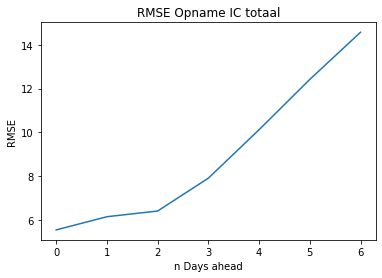

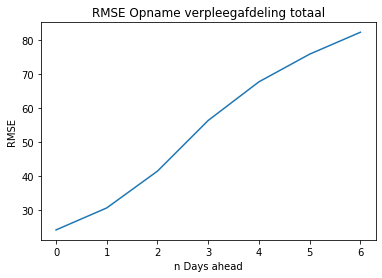

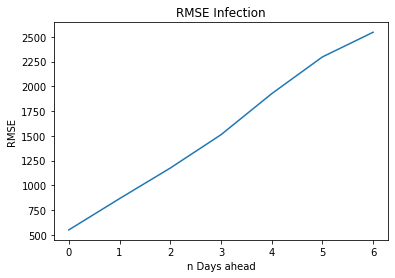

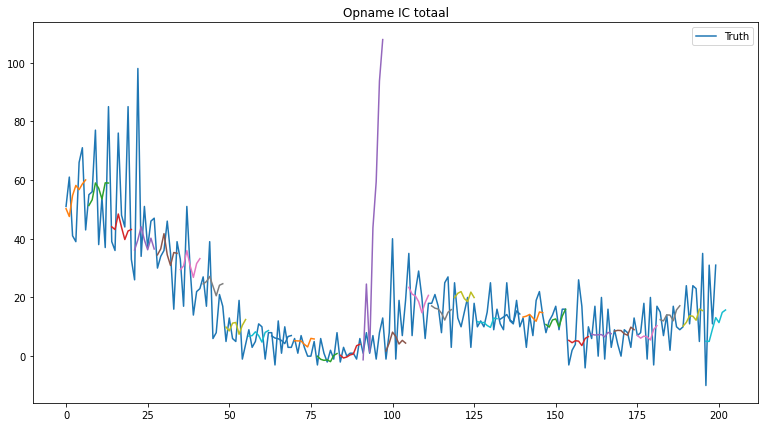

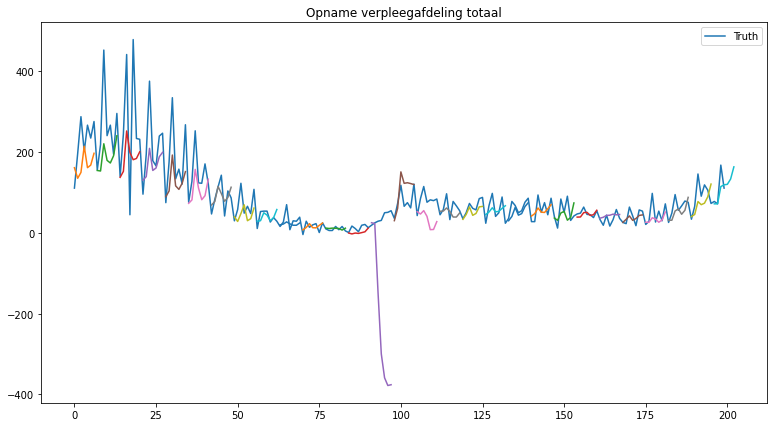

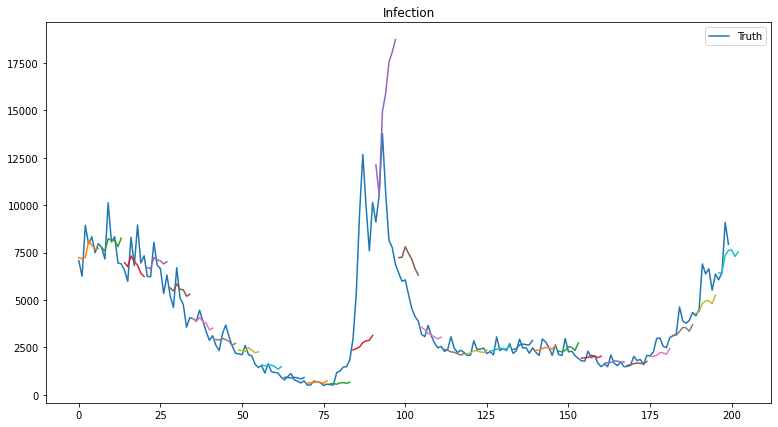

In [40]:
# make a prediction
def predict(model, X):
    X_3D = X.reshape(1, X.shape[0], X.shape[1])
    prediction = model.predict(X_3D)
    return prediction

# make a prediction for each given sample
def make_predictions(model, data):
    predictions = list()
    for sample in data:
        prediction = predict(model, sample)
        predictions.append(prediction[0])
    return np.array(predictions)

def test_model(model, test_X, test_y, scaler, original_values, n_seq):
    predictions = make_predictions(model, test_X)

    # Reverse all the scaling
    inv_X, inv_pred = inverse_scale(test_X, predictions, scaler, original_values, n_seq)

    inv_X, inv_truth = inverse_scale(test_X, test_y, scaler, original_values, n_seq)

    
    # calculate RMSE
    feature_names = ['Opname IC totaal', 'Opname verpleegafdeling totaal', 'Infection']
    for i in range(inv_truth.shape[2]):
        print(f'RMSE {feature_names[i]}')
        scores = list()
        for c in range(inv_truth.shape[1]):
            rmse = np.sqrt(mean_squared_error(inv_truth[:, c, i], inv_pred[:, c, i]))
            print(f'Day {c}: {rmse}')
            scores.append(rmse)
        plt.figure(i)
        plt.title(f'RMSE {feature_names[i]}')
        plt.plot(scores)
        plt.ylabel('RMSE')
        plt.xlabel('n Days ahead')
        

    # Plot a few predictions
    for i in range(inv_truth.shape[2]):
        plt.figure(i + 10, figsize=(13, 7))
        plt.title(feature_names[i])
        plt.plot(inv_truth[:, 0, i], label='Truth')
        for c in range(0, inv_pred.shape[0], n_seq):
            plt.plot(np.arange(c, c+inv_pred.shape[1]), inv_pred[c, :, i])
        plt.legend()

# During the data shift some values are dropped at the end and at the start of the data
adjusted_original_values = features.values[n_lag:-(n_seq - 1)]

test_model(model, test_X, test_y, scaler, adjusted_original_values[-n_tests:], n_seq)

## Conclusie

Uit de uiteindelijke scores en predictions blijkt dat terwijl het model redelijk de structuur van de data kan volgen de variantie in de correctheid van de voorspelling hoog is.

Sommmige predictions zijn redelijk fout, vooral de gigantische outlier in het midden van de data.

Zoals in de RMSE grafieken te zien is gaat de betrouwbaarheid linear omlaag, echter is de stijging relatief anders.

- Bij IC opnames ligt de RMSE ongeveer 2.5 keer zo hoog na de 7 dagen.
- Bij kliniek opnames ongeveer 3.2 keer zo hoog.
- Bij Infection wel 5 keer zo hoog.

Hieruit blijkt dat het model het beste is in het voorspellen van de IC opnames in vergelijking tot de andere features. Dit is ook het doel van het model dus dat komt goed uit.

Met een RMSE van ongeveer 14 op dag 7 is het model redelijk goed in het voorspellen van de volgende week.

Een lagere RMSE is zeer onwaarschijnlijk, dit omdat de data flink schommelt van dag op dag. De RMSE score hangt dus maar net af van waar de data die dag op uit schiet.

Dit is ook te zien aan de forecasts zelf, ze volgen niet echt het patroon van de data maar zoeken het midden op. Dit is een teken dat de dag op dag schommeling niet echt een patroon heeft dat het model kon vinden en is dus meer noise dan patroon.

Belangrijker is de uiteindelijke trend die het gemiddelde volgt daaruit volgt of er een stijging of daling verwacht kan worden volgende week.

Het blijft ook een feit dat de hoeveelheid data die beschikbaar is nog laag is, een deel van de data raakt verloren in het preprocessen en een deel is nodig voor de test set en validatie set.

Met meer data kan het model beter de uiteindelijke trend vinden en mogelijk minder gevoelig zijn voor pieken.

Met meer data is het ook mogelijk om te trainen op week gemiddeldes, om zo minder gevoelig te zijn voor de schommeling die dag op dag plaats vindt. Dit is momenteel niet mogelijk want met wekelijkse data is er simpelweg te weinig data om een model goed te trainen.

### Model

Tijdens het opstellen van het uiteindelijke model zijn een aantal complexere modellen gepropreerd met bijvoorbeeld meerdere LSTM lagen, de resultaten waren echter hetzelfde en dit zorgt enkel voor meer trainingsduur.

Ook een dropout laag is getest tijdens het opstellen, deze gaf ook geen betere resultaten en deed meer kwaad dan goed omdat er al zo weinig data is.

Andere activatiefuncties boden ook geen betere resultaten.

### Mogelijkheden

Een ander aantal dagen in het verleden gebruiken kan mogelijk een uitbreiding zijn die toegevoegd kan worden aan de parameter tuner.

Daarnaast zijn CNN's ook een potentiele optie om te proberen, mogelijk in combinatie met een LSTM.

Ook kan een ensable model een goed idee zijn om de hoge variantie te verhelpen.

